# Citation Analysis: Journals Cited by a Research Organization

This notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to discover what academic journals are most frequenlty cited by authors affiliated to a selected research organization. These are the steps: 

1. We start from a specific organization GRID ID (and other parameters of choice)
2. Using the [publications API](https://docs.dimensions.ai/dsl/datasource-publications.html), we extract all publications authored by researchers at that institution. For each publication, we store all outgoing citations IDs using the `reference_ids` field
3. We query the API again to obtain other useful metadata for those outgoing citations e.g. title, publisher, journals etc..  
4. We analyse the data, in particular by segmenting it by journal and publisher 

## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the *Getting Started* tutorial.


In [1]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *
import sys, json, time, os
from tqdm.notebook import tqdm
import pandas as pd
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

==
Logging in..
Dimcli - Dimensions API Client (v0.9.1)
Connected to: https://app.dimensions.ai - DSL v1.31
Method: dsl.ini file


A couple of utilities to simplify exporting the results we find as CSV files:

## 1. Choosing a Research Organization

We can use the [organizations API](https://docs.dimensions.ai/dsl/datasource-organizations.html) to find the [GRID ID](https://grid.ac/institutes) for Berkeley University.

In [2]:
%%dsldf 

search organizations for "berkeley university" return organizations

Returned Organizations: 1 (total = 1)
Time: 0.59s


,state_name,acronym,city_name,linkout,name,country_name,types,longitude,latitude,id
0,California,UCB,Berkeley,[http://www.berkeley.edu/],"University of California, Berkeley",United States,[Education],-122.258575,37.87216,grid.47840.3f


The ID we are looking for is [grid.47840.3f](https://www.grid.ac/institutes/grid.47840.3f).

### 1.1 Selecting a Field of Research ID

Similarly, we can use the API to identify relevant Field of Research (FoR) categories for Berkeley University. 

By using a specific FOR category we can make the subsequent data extraction & analysis a bit more focused. 

In [3]:
%%dsldf

search publications 
    where research_orgs.id = "grid.47840.3f"
    return category_for limit 10

Returned Category_for: 10
Time: 0.80s


,id,count,name
0,2206,39983,06 Biological Sciences
1,2209,35966,09 Engineering
2,2202,34844,02 Physical Sciences
3,2211,30612,11 Medical and Health Sciences
4,2203,20993,03 Chemical Sciences
5,2201,18004,01 Mathematical Sciences
6,2208,15779,08 Information and Computing Sciences
7,2581,15198,0601 Biochemistry and Cell Biology
8,2620,11982,0604 Genetics
9,2217,11622,17 Psychology and Cognitive Sciences


For example, let's focus on **08 Information and Computing Sciences**,  ID `2208` - 

Finally, we can also select a specific year range, e.g. the **last five years**. 

Let's save all of these variables so that we can reference them later on. 



In [4]:
GRIDID = "grid.47840.3f" #@param {type:"string"}

FOR_CODE = "2208"  #@param {type:"string"}

    
#@markdown The start/end year of publications used to extract patents
YEAR_START = 2015 #@param {type: "slider", min: 1950, max: 2020}
YEAR_END = 2021 #@param {type: "slider", min: 1950, max: 2020}

if YEAR_END < YEAR_START:
  YEAR_END = YEAR_START


## 2. Getting the IDs of the outgoing citations  

In this section we use the Publications API to extract the Dimensions ID of all publications referenced by authors in the selected research organization. 

These identifiers can be found in the `reference_ids` field. 


In [5]:
publications = dsl.query_iterative(f"""

    search publications 
        where research_orgs.id = "{GRIDID}"
        and year in [{YEAR_START}:{YEAR_END}]
        and category_for.id="{FOR_CODE}"
        return publications[id+doi+unnest(reference_ids)]
        
""")

#
# preview the data
pubs_and_citations = publications.as_dataframe()
pubs_and_citations.head(5)

Starting iteration with limit=1000 skip=0 ...
0-1000 / 4478 (1.18s)
1000-2000 / 4478 (1.10s)
2000-3000 / 4478 (1.17s)
3000-4000 / 4478 (1.17s)
4000-4478 / 4478 (0.98s)
4478-4478 / 4478 (0.86s)
===
Records extracted: 106119


,id,doi,reference_ids
0,pub.1137371560,10.1016/j.chb.2021.106814,pub.1104586211
1,pub.1137371560,10.1016/j.chb.2021.106814,pub.1019022681
2,pub.1137371560,10.1016/j.chb.2021.106814,pub.1010603626
3,pub.1137371560,10.1016/j.chb.2021.106814,pub.1007402080
4,pub.1137371560,10.1016/j.chb.2021.106814,pub.1070970563


### 2.1 Removing duplicates and counting most frequent citations

Since multiple authors/publications from our organization will be referencing the same target publications, we may have various duplicates in our `reference_ids` column. 

So want to remove those duplicates, while at the same time retaining that information by adding a new column `size` that counts how frequenlty a certain publication was cited. 

This can be easily achieved using [panda's group-by](https://stackoverflow.com/questions/35584085/how-to-count-duplicate-rows-in-pandas-dataframe) function: 

In [6]:
# consider only IDs column
df = pubs_and_citations[['reference_ids']]
# group by ID and count
citations = df.groupby(df.columns.tolist(),as_index=False).size().sort_values("size", ascending=False)
# preview the data, most cited ID first
citations.head(10)

,reference_ids,size
55446,pub.1093359587,148
62647,pub.1095689025,108
26134,pub.1038140272,81
6600,pub.1009767488,67
35747,pub.1052031051,66
59629,pub.1094727707,64
31157,pub.1045321436,61
56285,pub.1093626237,52
40184,pub.1061179979,52
6794,pub.1010020120,50


## 3. Enriching the citations IDs with other publication metadata 

In this step we use the outgoing citations IDs obtained above to query the [publications API](https://docs.dimensions.ai/dsl/datasource-publications.html) again. 

The goal is to retrieve more publications metadata so to be able to 'group' citations based on criteria of interest e.g. what journal they belong to. For example: 

* source_title
* publisher 
* year
* doi

NOTE Since we can have lots of publications to go through, the IDs list is *chunked* into smaller groups so to ensure the resulting API query is never too long ([more info here](https://api-lab.dimensions.ai/cookbooks/1-getting-started/6-Working-with-lists.html#5.-How-Long-can-lists-get?)). 

In [7]:

#
# get a list of citation IDs
pubids = list(citations['reference_ids'])


#
# DSL query - PS change the return statement to extract different metadata of interest 
query_template = """search publications 
                    where id in {}
                    return publications[id+doi+journal+year+publisher+type+issn]
                    limit 1000"""


#
# loop through all references-publications IDs in chunks and query Dimensions 
print(f"===\nExtracting publications data for {len(pubids)} citations...")
results = []
BATCHSIZE = 400
VERBOSE = False # set to True to see extraction logs

for chunk in tqdm(list(chunks_of(pubids, BATCHSIZE))):
    query = query_template.format(json.dumps(chunk))
    data = dsl.query(query, verbose=VERBOSE)
    results += data.publications
    time.sleep(0.5)

#
# save the citing pub data into a dataframe, remove duplicates and save
pubs_cited = pd.DataFrame().from_dict(results)
print("===\nCited Publications found: ", len(pubs_cited))


#
# transform the 'journal' column cause it contains nested data 
temp = pubs_cited['journal'].apply(pd.Series).rename(columns={"id": "journal.id", 
                                                              "title": "journal.title"}).drop([0], axis=1)
pubs_cited = pd.concat([pubs_cited.drop(['journal'], axis=1), temp], axis=1).sort_values('type')
pubs_cited.head(10)



===
Extracting publications data ...


  0%|          | 0/188 [00:00<?, ?it/s]

===
Cited Publications found:  74810


,doi,issn,type,year,id,publisher,journal.id,journal.title
0,10.1126/scirobotics.aau4984,[2470-9476],article,2019.0,pub.1111459810,American Association for the Advancement of Sc...,jour.1291981,Science Robotics
62672,10.1103/physrevlett.67.2339,"[0031-9007, 1079-7114]",article,1991.0,pub.1060803371,American Physical Society (APS),jour.1018277,Physical Review Letters
62671,10.1109/2.116849,"[0018-9162, 1558-0814]",article,1991.0,pub.1061105026,Institute of Electrical and Electronics Engine...,jour.1122253,Computer
62670,10.1088/0954-898x_3_2_006,"[0954-898X, 1361-6536]",article,1992.0,pub.1059115905,Taylor & Francis,jour.1111966,Network Computation in Neural Systems
62669,10.1088/0954-898x_3_2_009,"[0954-898X, 1361-6536]",article,1992.0,pub.1059115908,Taylor & Francis,jour.1111966,Network Computation in Neural Systems
62668,10.1103/revmodphys.64.1045,"[0034-6861, 1539-0756]",article,1992.0,pub.1060839239,American Physical Society (APS),jour.1018362,Reviews of Modern Physics
62667,10.1109/18.119725,"[0018-9448, 1557-9654]",article,1992.0,pub.1061098596,Institute of Electrical and Electronics Engine...,jour.1124767,IEEE Transactions on Information Theory
62666,10.1109/18.119732,"[0018-9448, 1557-9654]",article,1992.0,pub.1061098603,Institute of Electrical and Electronics Engine...,jour.1124767,IEEE Transactions on Information Theory
62665,10.1109/18.119733,"[0018-9448, 1557-9654]",article,1992.0,pub.1061098604,Institute of Electrical and Electronics Engine...,jour.1124767,IEEE Transactions on Information Theory
62664,10.1109/18.119749,"[0018-9448, 1557-9654]",article,1992.0,pub.1061098620,Institute of Electrical and Electronics Engine...,jour.1124767,IEEE Transactions on Information Theory


### 3.1 Adding the citations counts 

We achieve this by joining this data with the ones we extracted before, that is, `citations`

> Note: if there are a lot of publications, this step can take some time. 

In [8]:
pubs_cited = pubs_cited.merge(citations, left_on='id', right_on='reference_ids')

pubs_cited.head(10)

,doi,issn,type,year,id,publisher,journal.id,journal.title,reference_ids,size
0,10.1126/scirobotics.aau4984,[2470-9476],article,2019.0,pub.1111459810,American Association for the Advancement of Sc...,jour.1291981,Science Robotics,pub.1111459810,10
1,10.1103/physrevlett.67.2339,"[0031-9007, 1079-7114]",article,1991.0,pub.1060803371,American Physical Society (APS),jour.1018277,Physical Review Letters,pub.1060803371,1
2,10.1109/2.116849,"[0018-9162, 1558-0814]",article,1991.0,pub.1061105026,Institute of Electrical and Electronics Engine...,jour.1122253,Computer,pub.1061105026,1
3,10.1088/0954-898x_3_2_006,"[0954-898X, 1361-6536]",article,1992.0,pub.1059115905,Taylor & Francis,jour.1111966,Network Computation in Neural Systems,pub.1059115905,1
4,10.1088/0954-898x_3_2_009,"[0954-898X, 1361-6536]",article,1992.0,pub.1059115908,Taylor & Francis,jour.1111966,Network Computation in Neural Systems,pub.1059115908,1
5,10.1103/revmodphys.64.1045,"[0034-6861, 1539-0756]",article,1992.0,pub.1060839239,American Physical Society (APS),jour.1018362,Reviews of Modern Physics,pub.1060839239,1
6,10.1109/18.119725,"[0018-9448, 1557-9654]",article,1992.0,pub.1061098596,Institute of Electrical and Electronics Engine...,jour.1124767,IEEE Transactions on Information Theory,pub.1061098596,1
7,10.1109/18.119732,"[0018-9448, 1557-9654]",article,1992.0,pub.1061098603,Institute of Electrical and Electronics Engine...,jour.1124767,IEEE Transactions on Information Theory,pub.1061098603,1
8,10.1109/18.119733,"[0018-9448, 1557-9654]",article,1992.0,pub.1061098604,Institute of Electrical and Electronics Engine...,jour.1124767,IEEE Transactions on Information Theory,pub.1061098604,1
9,10.1109/18.119749,"[0018-9448, 1557-9654]",article,1992.0,pub.1061098620,Institute of Electrical and Electronics Engine...,jour.1124767,IEEE Transactions on Information Theory,pub.1061098620,1


## 4. Journal Analysis

Finally, we can analyze the citing publications by grouping them by source journal. This can be achieved easily thanks to pandas' Dataframe methods.  

### 4.1 Number of Unique journals

In [9]:
pubs_cited['journal.id'].describe()

count            50974
unique            6037
top       jour.1031287
freq               586
Name: journal.id, dtype: object

### 4.2 Most frequent journals

In [10]:
journals = pubs_cited.value_counts(['journal.title', 'publisher'])
journals = journals.to_frame().reset_index().rename(columns= {0: 'citations', 'journal.title' : 'title'})
journals.index.name = 'index'

#preview
journals.head(100)

,title,publisher,citations
index,,,
0,ACM Transactions on Graphics,Association for Computing Machinery (ACM),586
1,IEEE Transactions on Information Theory,Institute of Electrical and Electronics Engine...,583
2,Nature,Springer Nature,498
3,Proceedings of the National Academy of Science...,Proceedings of the National Academy of Sciences,494
4,Science,American Association for the Advancement of Sc...,486
...,...,...,...
95,Chemical Physics Letters,Elsevier,80
96,2009 IEEE Intelligent Vehicles Symposium,Institute of Electrical and Electronics Engine...,80
97,ACM SIGOPS Operating Systems Review,Association for Computing Machinery (ACM),79


### 4.3 Top 50 journals chart, by publisher

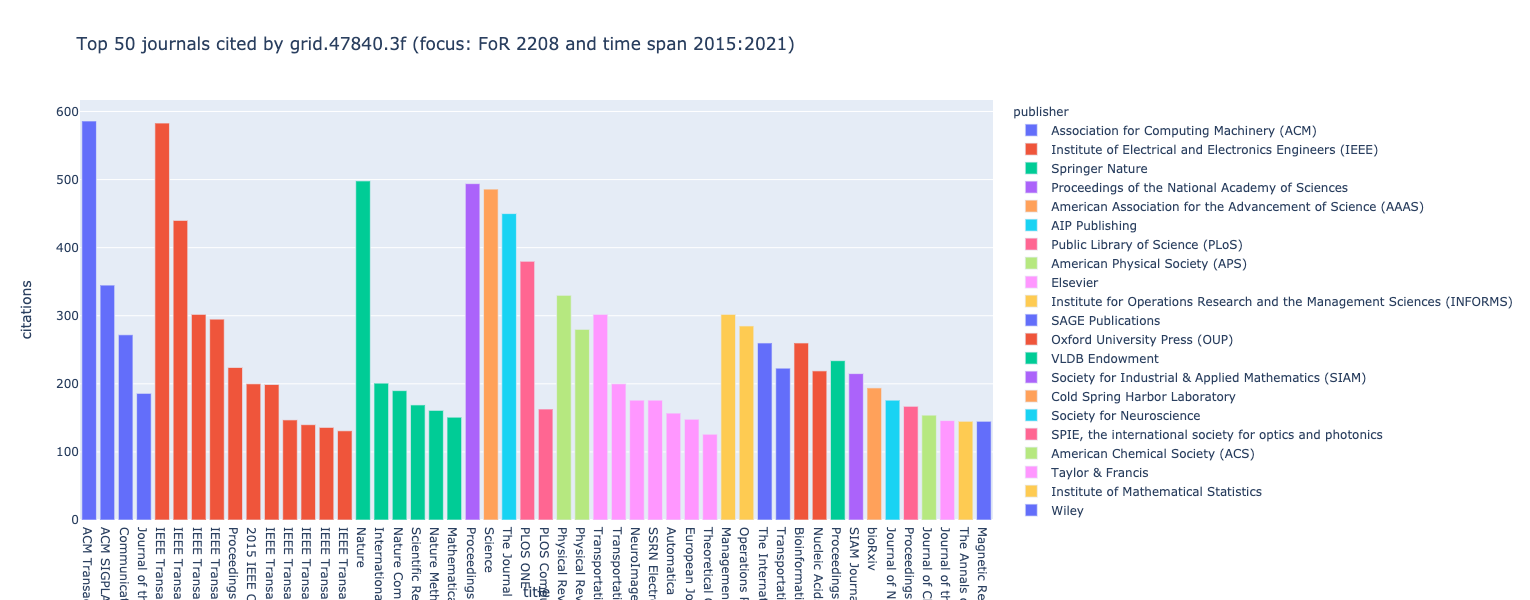

In [13]:
px.bar(journals[:50], 
       x="title", y="citations", color="publisher",
       height=600,
       title=f"Top 50 journals cited by {GRIDID} (focus: FoR {FOR_CODE} and time span {YEAR_START}:{YEAR_END})")

### 4.4 Top 20 journals by year of the cited publication

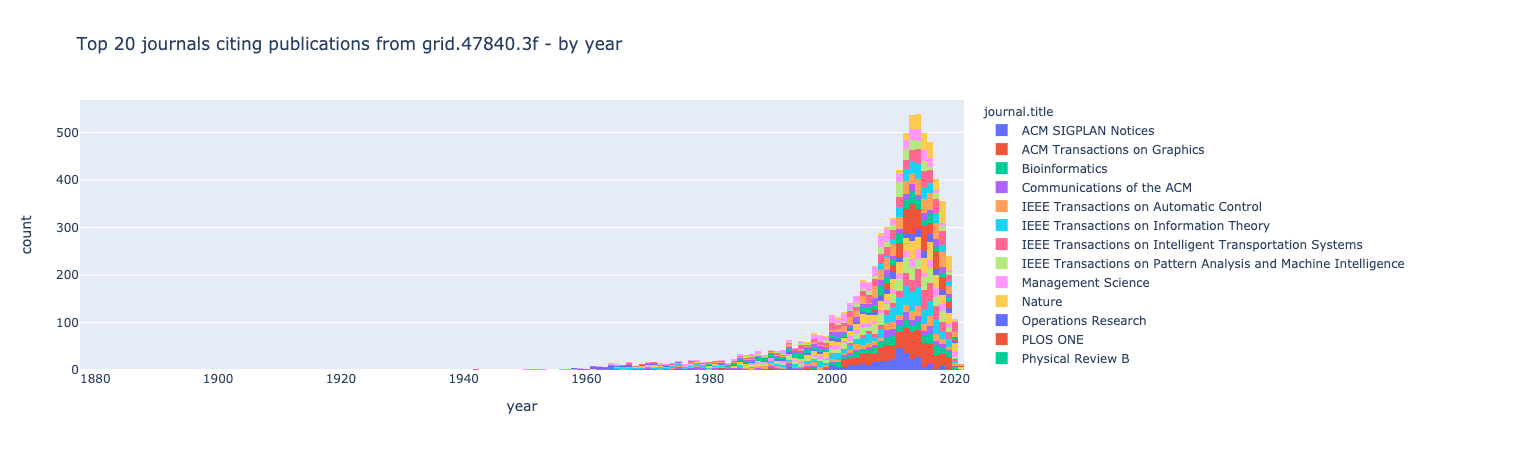

In [12]:

THRESHOLD = 20  #@param {type: "slider", min: 10, max: 100}

# suppress empty values
pubs_cited.fillna("-no value-", inplace=True)

# make publications list smaller by only showing top journals
pubs_citing_topjournals = pubs_cited[pubs_cited['journal.title'].isin(list(journals[:THRESHOLD]['title']))].sort_values('journal.title')

# build histogram
px.histogram(pubs_citing_topjournals, 
             x="year", 
             color="journal.title", 
             title=f"Top {THRESHOLD} journals citing publications from {GRIDID} - by year")

---
## Conclusions

In this notebook we have shown how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to discover what academic journals are most frequenlty cited by authors affiliated to a selected research organization. 

This only scratches the surface of the possible applications of publication data, but hopefully it'll give you a few basic tools to get started building your own applications. For more background, see the [list of fields](https://docs.dimensions.ai/dsl/datasource-publications.html) available via the Publications API. 
